In [1]:
import numpy as np
import torch
import os
import pandas as pd
import torch_geometric
import pickle
import tqdm
import random

/home/icb/vnicolas.goedert/miniconda3/envs/RFAM/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
rfam_dir = "../rfam/data/raw/processed/release-14.8"
rfam = "RF04088"

In [3]:
from RNARepLearn.datasets import SingleMaskedRfamDataset
rfam_dataset = SingleMaskedRfamDataset(rfam_dir,rfam,15)
rfam_dataset

Processing...
Done!


SingleMaskedRfamDataset(4988)

In [4]:
train_size = int(0.8 * len(rfam_dataset))
test_size = len(rfam_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(rfam_dataset, [train_size, test_size])

In [5]:
from torch_geometric.loader import DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [9]:
##Model
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(rfam_dataset.num_node_features, 64)
        self.Wk = Linear(64,64)
        self.Wq = Linear(64,64)

        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        #build representation
        # input -> V_N,D
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        #attention
        # linear projection Wq_D,D and Wk_D,D
        w_q = self.Wq(x)
        w_k = self.Wk(x)

        print(x.shape)
        print(w_q.shape)
        print(w_k.shape) 
        
        queries = torch.tensordot(x,w_q)
        keys = torch.tensordot(x,w_k)
        print(queries.shape)
        
        transpose=keys.T
        dot_prod = torch.tensordot(queries, transpose)
        bpp = F.softmax(dot_prod, dim=1)
        
        
        x = self.conv2(x, edge_index)

        return F.softmax(x, dim=1), bpp
    
def mask(batch, percentage):
    mask = [random.randrange(100) < percentage for i in range(batch.x.shape[0])]
    # mask nodes
    batch.x[mask] = torch.tensor([0.0,0.0,0.0,0.0],dtype=torch.float64)
    
    # mask edges
    masked_bases = np.asarray(range(len(mask)))[mask]
    masked_edges_index_from = np.where(np.isin(batch.edge_index[0],masked_bases))
    masked_edges_index_to = np.where(np.isin(batch.edge_index[1],masked_bases))
    masked_edges = np.union1d(masked_edges_index_from, masked_edges_index_to)
    
    #batch.edge_attr[masked_edges]=0.0
    
    return batch

In [10]:
##Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
model = model.double()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

n_epochs = 20


In [11]:
##Training
train_hist = {}
train_hist["loss"]=[]
model.train()
cel_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()

for epoch in range(n_epochs):
    for idx, batch in enumerate(train_loader):
        batch = mask(batch,15)
        batch.to(device)
        optimizer.zero_grad()
        out,bpp = model(batch)
    
        node_loss = cel_loss(out,batch.y)
        #edge_loss = mse_loss(out,)
        
        loss = node_loss

        loss.backward()
        optimizer.step()
        train_hist["loss"].append(loss.item())
        
        print('\r[Epoch %4d/%4d] [Batch %4d/%4d] Loss: % 2.2e' % (epoch + 1, n_epochs, 
                                                                idx + 1, len(train_loader), 
                                                                loss.item()))
    

torch.Size([6545, 64])
torch.Size([6545, 64])
torch.Size([6545, 64])
torch.Size([])


IndexError: dimension specified as -2 but tensor has no dimensions

In [11]:
model(batch).shape

torch.Size([6562, 4])

In [12]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
test_data = next(iter(test_loader))
test_data.to(device)
pred = model(test_data)
pred

tensor([[0.8031, 0.0166, 0.1088, 0.0714],
        [0.8020, 0.0165, 0.1095, 0.0720],
        [0.0278, 0.0197, 0.0144, 0.9381],
        ...,
        [0.7696, 0.0213, 0.1157, 0.0933],
        [0.0286, 0.0198, 0.0154, 0.9362],
        [0.0282, 0.0199, 0.0153, 0.9366]], device='cuda:0',
       dtype=torch.float64, grad_fn=<SoftmaxBackward0>)

In [13]:
from sklearn.metrics import roc_curve

In [14]:
yscore = pred.detach().cpu().numpy()

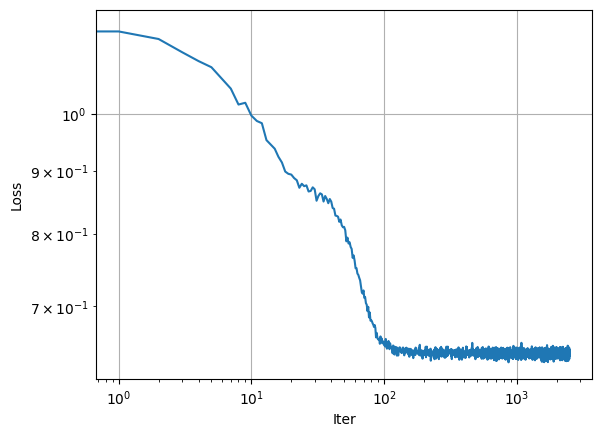

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.loglog(np.abs(train_hist['loss']))
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')
ax.grid(True)

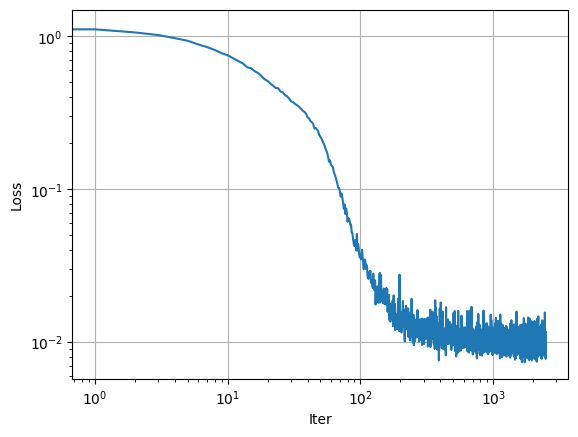

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.loglog(np.abs(train_hist['loss']))
ax.set_xlabel('Iter')
ax.set_ylabel('Loss')
ax.grid(True)